In [1]:
from glob import glob
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy

In [2]:
log_path=sorted(glob('./res_log/*'))

In [3]:
# for log_file in log_path:
#     with open(log_file) as f:
#         if 'Early' in f.read():
#             print(log_file)

In [4]:
rx_dict = {
    'error_down': re.compile(r'down sim 500: (?P<error_down>.*)\n'),
    'mean_dist': re.compile(r'both up and down: (?P<mean_dist>.*)\n'),
    'error_up': re.compile(r'up sim 500: (?P<error_up>.*)\n'),
    'error_stay': re.compile(r'stay sim 500: (?P<error_stay>.*)\n'),
    'total_params':re.compile(r'Total params: (?P<total_params>.*)\n'),
}

In [5]:
def _parse_line(line):
    for key, rx in rx_dict.items():
        match = rx.search(line)
        if match:
            return key, match
    # if there are no matches
    return None, None

In [6]:
def parse_file(filepath):

    # open the file and read through it line by line
    with open(filepath, 'r') as file_object:
        line = file_object.readline()
        while line:
            # at each line check for a match with a regex
            key, match = _parse_line(line)

            if key == 'error_down':
                error_down = match.group('error_down')
                error_down=int(error_down)
                
            if key == 'mean_dist':
                mean_dist = match.group('mean_dist')
                mean_dist=float(mean_dist)
                
            if key == 'error_up':
                error_up = match.group('error_up')
                error_up=int(error_up)
                
            if key == 'error_stay':
                error_stay = match.group('error_stay')
                error_stay=int(error_stay)
                
            if key == 'total_params':
                total_params = match.group('total_params')
                
            line = file_object.readline()
            

    return [error_down,error_up,error_stay,mean_dist,total_params]

In [7]:
res_list=[]
for path in log_path:
    _log=parse_file(path)
    if len(os.path.basename(path).split("_"))==7:
        int_path=[''.join(os.path.basename(path).split("_")[:6])]
    else:
        int_path=[''.join(os.path.splitext(os.path.basename(path))[0].split("_"))]
    int_path=int(int_path[0])
    _log.append(int_path)
    
    res_list.append(_log)
    

In [8]:
res_arr=np.array(res_list)

In [9]:
res_df = pd.DataFrame(res_arr, columns=['error_down', 'error_up', 'error_stay', 'mean_dist', 'total_params'
                                       , 'file_name'])

In [10]:
res_df

,error_down,error_up,error_stay,mean_dist,total_params,file_name
0,0,0,0,137.2223520649639,313,101010111
1,0,0,0,134.14566820393335,313,101010111
2,0,0,0,135.36104830422676,313,101010111
3,0,0,0,134.84112066232808,313,101010111
4,0,0,1,132.0152592228053,643,101010222
...,...,...,...,...,...,...
519,0,0,0,133.2426979011194,"13,683",808080111
520,0,0,0,130.90186270358987,"33,123",808080222
521,0,0,0,132.44833418215222,"33,123",808080222
522,2,0,2,130.8339218679489,"33,123",808080222


In [11]:
res_df.to_csv("res_df.csv", mode='w')

In [12]:
for i in range(len(res_arr)):
    res_arr[i,4]=int(res_arr[i,4].replace(',',''))

In [13]:
std_temp=res_arr[:,:4].astype(np.float32)
std_arr=np.zeros((int(len(res_arr)/4),3))
for i in range(0,int(len(res_arr)/4)):
    std_arr[i,0]=np.mean(std_temp[4*i:4*(i+1),-1])
    std_arr[i,1]=np.std(std_temp[4*i:4*(i+1),-1])
    std_arr[i,2]=res_arr[4*i,4]

In [14]:
hyper_params=res_arr[::4,-1]
std_arr=np.hstack([std_arr,hyper_params.reshape(131,-1)])

In [15]:
std_df=pd.DataFrame(std_arr, columns=['mean_mean_dist', 'std_mean_dist', 'num_params','hyper_params'])

In [16]:
std_df

,mean_mean_dist,std_mean_dist,num_params,hyper_params
0,135.39254760742188,1.14104425907135,313.0,101010111
1,131.95924377441406,0.33274754881858826,643.0,101010222
2,133.3686981201172,0.5499991178512573,1023.0,202020111
3,132.17578125,0.5294870138168335,2283.0,202020222
4,133.71481323242188,0.8390873670578003,1503.0,202040111
...,...,...,...,...
126,131.50448608398438,0.3806193172931671,24923.0,808040222
127,133.78826904296875,0.3488175868988037,12003.0,808060111
128,131.00352478027344,0.5322102904319763,28623.0,808060222
129,133.6107177734375,0.33318275213241577,13683.0,808080111


In [17]:
def sep_func(param_char):
    sep_char = "[" + param_char[:2] + "," + param_char[2:4] + "," + param_char[4:6] + "]" + \
                ", [" + param_char[6] + "," + param_char[7] + "," + param_char[8] + "]"
    return sep_char

In [18]:
new_std_df = std_df.drop([0, 1, 66])

In [19]:
new_std_df

,mean_mean_dist,std_mean_dist,num_params,hyper_params
2,133.3686981201172,0.5499991178512573,1023.0,202020111
3,132.17578125,0.5294870138168335,2283.0,202020222
4,133.71481323242188,0.8390873670578003,1503.0,202040111
5,131.73175048828125,0.43111321330070496,3983.0,202040222
6,134.2682342529297,0.4578185975551605,1983.0,202060111
...,...,...,...,...
126,131.50448608398438,0.3806193172931671,24923.0,808040222
127,133.78826904296875,0.3488175868988037,12003.0,808060111
128,131.00352478027344,0.5322102904319763,28623.0,808060222
129,133.6107177734375,0.33318275213241577,13683.0,808080111


In [20]:
compare_table= copy.copy(new_std_df.values)
compare_table[:,:-1]=compare_table[:,:-1].astype(np.float32)/np.max(compare_table[:,:-1],axis=0).astype(np.float32)

In [21]:
compare_df=pd.DataFrame(compare_table, columns=['mean_mean_dist', 'std_mean_dist', 'num_params','hyper_params'])
compare_df

,mean_mean_dist,std_mean_dist,num_params,hyper_params
0,0.990964,0.462558,0.103302,202020111
1,0.9821,0.445307,0.230536,202020222
2,0.993535,0.705685,0.151772,202040111
3,0.978801,0.362573,0.402201,202040222
4,0.997648,0.385032,0.200242,202060111
...,...,...,...,...
123,0.977112,0.320107,2.51671,808040222
124,0.994081,0.293361,1.21206,808060111
125,0.97339,0.447597,2.89034,808060222
126,0.992762,0.280212,1.3817,808080111


In [22]:
new_std_df.values[:,:3]

array([['133.3686981201172', '0.5499991178512573', '1023.0'],
       ['132.17578125', '0.5294870138168335', '2283.0'],
       ['133.71481323242188', '0.8390873670578003', '1503.0'],
       ['131.73175048828125', '0.43111321330070496', '3983.0'],
       ['134.2682342529297', '0.4578185975551605', '1983.0'],
       ['132.4710235595703', '0.43359315395355225', '6483.0'],
       ['133.72833251953125', '0.6267560124397278', '2463.0'],
       ['132.4190216064453', '0.7382054328918457', '9783.0'],
       ['134.2493438720703', '0.6149956583976746', '1843.0'],
       ['132.56671142578125', '0.32288241386413574', '4323.0'],
       ['133.27468872070312', '0.4234205186367035', '2723.0'],
       ['132.0382080078125', '0.7493412494659424', '6423.0'],
       ['133.88681030273438', '0.5738113522529602', '3603.0'],
       ['131.8139190673828', '0.3636617660522461', '9323.0'],
       ['133.7472686767578', '1.1890389919281006', '4483.0'],
       ['132.08346557617188', '1.1675649881362915', '13023.0'],
  

In [23]:
compare_df.values[:,:3]

array([[0.9909637570381165, 0.46255767345428467, 0.10330203175544739],
       [0.9821000695228577, 0.4453066885471344, 0.23053620755672455],
       [0.9935354590415955, 0.7056853175163269, 0.15177218616008759],
       [0.9788008332252502, 0.3625728189945221, 0.4022013545036316],
       [0.9976475238800049, 0.38503244519233704, 0.20024235546588898],
       [0.9842938184738159, 0.3646584749221802, 0.654650092124939],
       [0.9936359524726868, 0.5271114110946655, 0.24871250987052917],
       [0.9839074015617371, 0.6208420991897583, 0.9878824353218079],
       [0.9975072145462036, 0.5172207951545715, 0.18610522150993347],
       [0.9850047826766968, 0.2715490460395813, 0.4365343749523163],
       [0.9902652502059937, 0.35610315203666687, 0.2749671936035156],
       [0.9810778498649597, 0.6302074790000916, 0.6485913395881653],
       [0.9948134422302246, 0.482584148645401, 0.3638291358947754],
       [0.9794113636016846, 0.30584511160850525, 0.9414318799972534],
       [0.9937766194343567

In [24]:
compare_df.to_csv("compare_df_fix.csv", mode='w')

In [25]:
compare_sum=compare_table[:,0]*0.8+1/compare_table[:,1]*0.1+compare_table[:,-2]*0.1

In [26]:
paper_data = np.hstack([compare_sum.reshape(-1,1),new_std_df.values[:, 3].reshape(-1,1)])

In [27]:
paper_data_df = pd.DataFrame(paper_data, columns=["score",'hyper_params'])

In [28]:
paper_data_df

,score,hyper_params
0,1.01929,202020111
1,1.0333,202020222
2,0.951712,202040111
3,1.09907,202040222
4,1.07786,202060111
...,...,...
123,1.34576,808040222
124,1.25735,808060111
125,1.29116,808060222
126,1.28925,808080111


In [29]:
one_ary = paper_data_df.values[0::2,:]

In [30]:
two_ary = paper_data_df.values[1::2,:]

In [46]:
for i in range (len(one_ary[:, 1])):
    one_ary[i, 1] = one_ary[i, 1][:6]

In [58]:
for i in range (len(two_ary[:, 1])):
    two_ary[i, 1] = two_ary[i, 1][:6]

In [62]:
one_res_list1 = []
for i in range (1, 5):
    for j in range (1, 5):
        mean_xy = 0
        for k in range (len(one_ary)):
            if one_ary[k, 1][:2] == str(i * 20) and one_ary[k, 1][2:4] == str(j * 20):
                mean_xy += one_ary[k,0]
        mean_xy = mean_xy / 4
        one_res_list1.append([mean_xy, i * 20, j * 20])

In [63]:
one_res_list2 = []
for i in range (1, 5):
    for j in range (1, 5):
        mean_xy = 0
        for k in range (len(one_ary)):
            if one_ary[k, 1][:2] == str(i * 20) and one_ary[k, 1][4:] == str(j * 20):
                mean_xy += one_ary[k,0]
        mean_xy = mean_xy / 4
        one_res_list2.append([mean_xy, i * 20, j * 20])

In [64]:
one_res_list3 = []
for i in range (1, 5):
    for j in range (1, 5):
        mean_xy = 0
        for k in range (len(one_ary)):
            if one_ary[k, 1][2:4] == str(i * 20) and one_ary[k, 1][4:] == str(j * 20):
                mean_xy += one_ary[k,0]
        mean_xy = mean_xy / 4
        one_res_list3.append([mean_xy, i * 20, j * 20])

In [65]:
one_res_list1

[[1.014589032001651, 20, 20],
 [1.0225563925610848, 20, 40],
 [1.1248387874746757, 20, 60],
 [1.0930538947327844, 20, 80],
 [1.063217401857139, 40, 20],
 [1.012686873819023, 40, 40],
 [1.0356644935458283, 40, 60],
 [1.127002167160327, 40, 80],
 [1.0601168378114598, 60, 20],
 [1.1398865183377842, 60, 40],
 [1.0606942064597351, 60, 60],
 [1.095159597055282, 60, 80],
 [0.9751985122900849, 80, 20],
 [1.045871070115456, 80, 40],
 [1.0502580123817724, 80, 60],
 [1.2217710114662945, 80, 80]]

In [66]:
one_res_list2

[[1.0381492165577368, 20, 20],
 [1.003316581660898, 20, 40],
 [1.1562516655970452, 20, 60],
 [1.0573206429545163, 20, 80],
 [1.0610266320935269, 40, 20],
 [1.045642098329712, 40, 40],
 [1.0860512496208305, 40, 60],
 [1.0458509563382479, 40, 80],
 [1.001949538727514, 60, 20],
 [1.109824559626898, 60, 40],
 [1.125682744601229, 60, 60],
 [1.1184003167086203, 60, 80],
 [1.094575654829549, 80, 20],
 [0.9999086277474707, 80, 40],
 [1.1413654506287523, 80, 60],
 [1.0572488730478358, 80, 80]]

In [67]:
one_res_list3

[[1.0556461387241738, 20, 20],
 [0.9870554592913169, 20, 40],
 [1.0295348919554659, 20, 60],
 [1.0408852939893782, 20, 80],
 [1.0027352122728646, 40, 20],
 [1.0695311495946769, 40, 40],
 [1.120306628030139, 40, 60],
 [1.028427864935667, 40, 80],
 [1.014833775906768, 60, 20],
 [1.028754012711499, 60, 40],
 [1.1569824404982945, 60, 60],
 [1.0708852707454506, 60, 80],
 [1.1224859153045201, 80, 20],
 [1.0733512457674863, 80, 40],
 [1.2025271499639572, 80, 60],
 [1.1386223593787246, 80, 80]]

In [75]:
two_res_list1 = []
for i in range (1, 5):
    for j in range (1, 5):
        mean_xy = 0
        for k in range (len(two_ary)):
            if two_ary[k, 1][:2] == str(i * 20) and two_ary[k, 1][2:4] == str(j * 20):
                mean_xy += two_ary[k,0]
        mean_xy = mean_xy / 4
        two_res_list1.append([mean_xy, i * 20, j * 20])

In [76]:
two_res_list2 = []
for i in range (1, 5):
    for j in range (1, 5):
        mean_xy = 0
        for k in range (len(two_ary)):
            if two_ary[k, 1][:2] == str(i * 20) and two_ary[k, 1][4:] == str(j * 20):
                mean_xy += two_ary[k,0]
        mean_xy = mean_xy / 4
        two_res_list2.append([mean_xy, i * 20, j * 20])

In [77]:
two_res_list3 = []
for i in range (1, 5):
    for j in range (1, 5):
        mean_xy = 0
        for k in range (len(two_ary)):
            if two_ary[k, 1][2:4] == str(i * 20) and two_ary[k, 1][4:] == str(j * 20):
                mean_xy += two_ary[k,0]
        mean_xy = mean_xy / 4
        two_res_list3.append([mean_xy, i * 20, j * 20])

In [78]:
two_res_list1

[[1.0766201131044788, 20, 20],
 [1.1078563688338043, 20, 40],
 [1.08716714654545, 20, 60],
 [1.268667324447715, 20, 80],
 [1.2039162679945319, 40, 20],
 [1.1723129038780282, 40, 40],
 [1.171372489148884, 40, 60],
 [1.170423815758454, 40, 80],
 [1.0751803923283987, 60, 20],
 [1.097604481119938, 60, 40],
 [1.1588584134576514, 60, 60],
 [1.2160485731987294, 60, 80],
 [1.1480050280739036, 80, 20],
 [1.1527823443176346, 80, 40],
 [1.236803479064823, 80, 60],
 [1.2936373067160514, 80, 80]]

In [79]:
two_res_list2

[[1.196913620283911, 20, 20],
 [1.1002308909548004, 20, 40],
 [1.1601609935394417, 20, 60],
 [1.0830054481532947, 20, 80],
 [1.0886598521786341, 40, 20],
 [1.026101973654075, 40, 40],
 [1.3836395432054547, 40, 60],
 [1.219624107741734, 40, 80],
 [1.117911557800245, 60, 20],
 [1.1289930061669442, 60, 40],
 [1.1432173979582732, 60, 60],
 [1.1575698981792546, 60, 80],
 [1.13990915445366, 80, 20],
 [1.2908729506714844, 80, 40],
 [1.1794950165872828, 80, 60],
 [1.2209510364599852, 80, 80]]

In [80]:
two_res_list3

[[1.0618479820483877, 20, 20],
 [1.090255177726733, 20, 40],
 [1.2584548129030906, 20, 60],
 [1.0931638288231016, 20, 80],
 [1.0742558461096303, 40, 20],
 [1.0701560878907013, 40, 40],
 [1.2023458503956572, 40, 60],
 [1.1837983137534165, 40, 80],
 [1.1107136646004456, 60, 20],
 [1.1701857170014582, 60, 40],
 [1.1714192914488661, 60, 60],
 [1.2018828551660383, 60, 80],
 [1.2965766919579864, 80, 20],
 [1.215601838828412, 80, 40],
 [1.2342929965428389, 80, 60],
 [1.2023054927917123, 80, 80]]

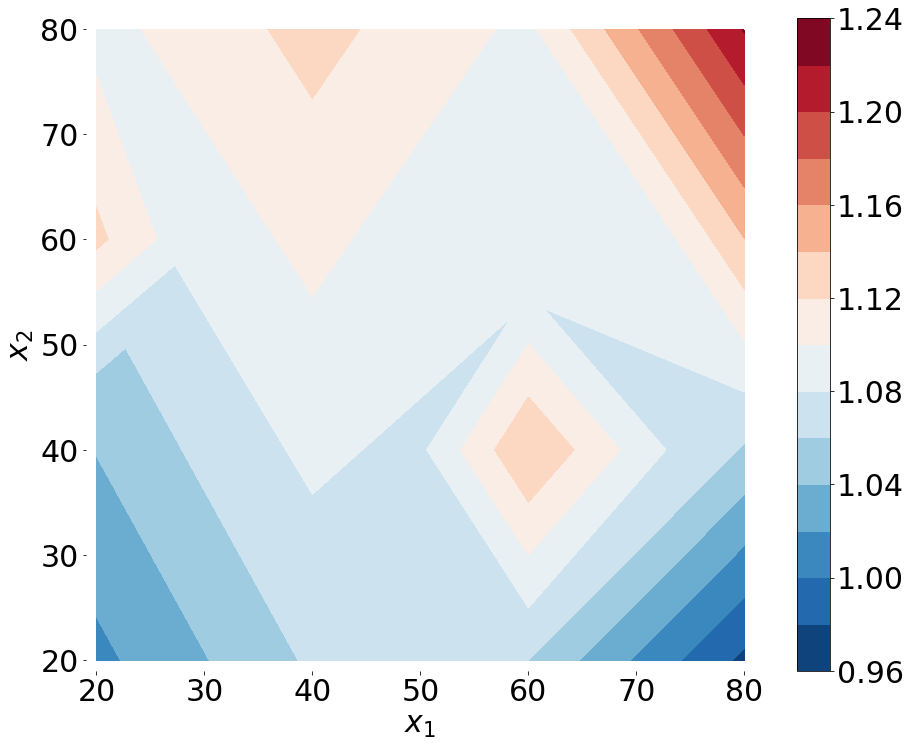

In [146]:
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import numpy as np
xi = np.array(one_res_list1)[:,1]
yi = np.array(one_res_list1)[:,2]
z = np.array(one_res_list1)[:,0]
triang = tri.Triangulation(xi, yi)
interpolator = tri.LinearTriInterpolator(triang, z)
Xi, Yi = np.meshgrid(xi, yi)
zi = interpolator(Xi, Yi)
plt.figure(figsize = (15,12))
plt.rcParams['font.size'] = 30
plt.contour(xi, yi, zi, levels=0, linewidths=0, colors='k')
cntr = plt.contourf(xi, yi, zi, levels=15, cmap="RdBu_r")
plt.colorbar(cntr)
plt.xlim(19, 81)
plt.ylim(19, 81)
plt.xlabel("${x_1}$")
plt.ylabel("${x_2}$")
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

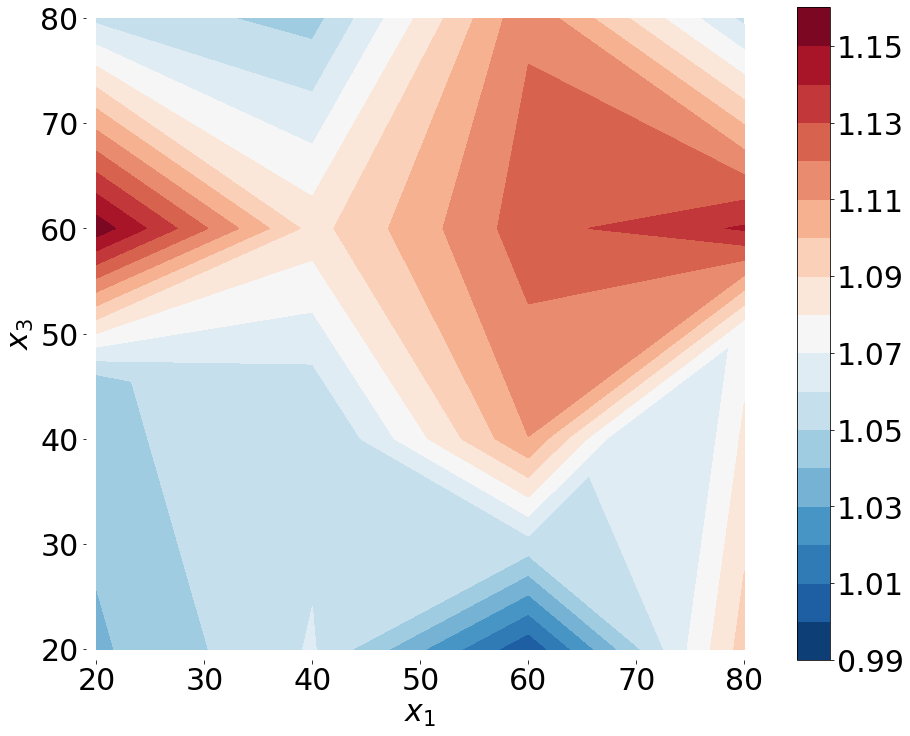

In [147]:
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import numpy as np
xi = np.array(one_res_list2)[:,1]
yi = np.array(one_res_list2)[:,2]
z = np.array(one_res_list2)[:,0]
triang = tri.Triangulation(xi, yi)
interpolator = tri.LinearTriInterpolator(triang, z)
Xi, Yi = np.meshgrid(xi, yi)
zi = interpolator(Xi, Yi)
plt.figure(figsize = (15,12))
plt.rcParams['font.size'] = 30
plt.contour(xi, yi, zi, levels=0, linewidths=0, colors='k')
cntr = plt.contourf(xi, yi, zi, levels=15, cmap="RdBu_r")
plt.colorbar(cntr)
plt.xlim(19, 81)
plt.ylim(19, 81)
plt.xlabel("${x_1}$")
plt.ylabel("${x_3}$")
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

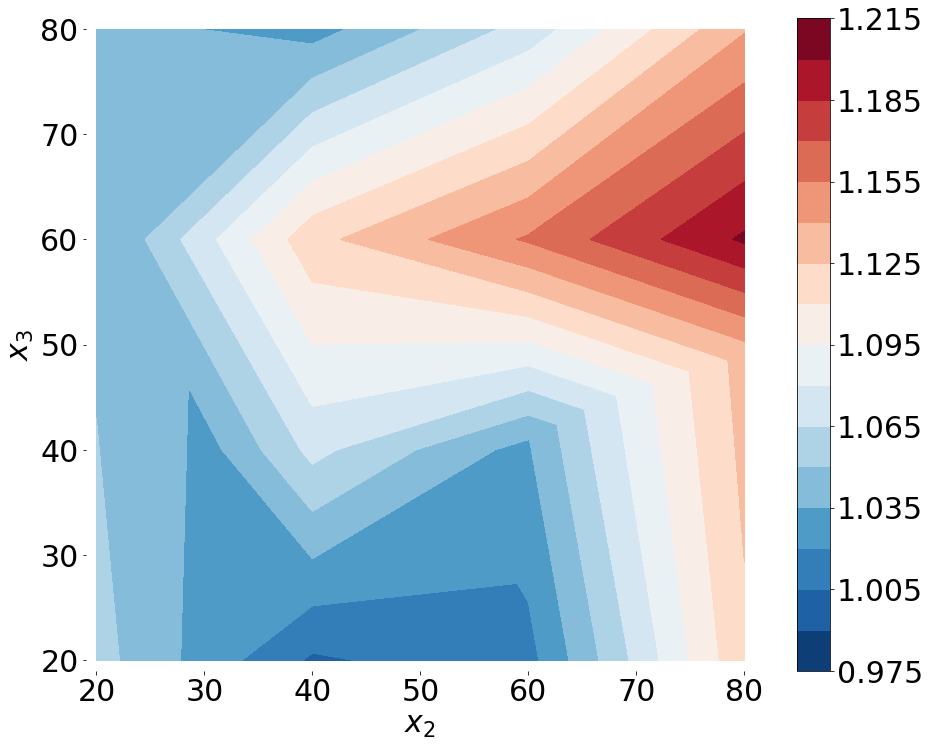

In [148]:
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import numpy as np
xi = np.array(one_res_list3)[:,1]
yi = np.array(one_res_list3)[:,2]
z = np.array(one_res_list3)[:,0]
triang = tri.Triangulation(xi, yi)
interpolator = tri.LinearTriInterpolator(triang, z)
Xi, Yi = np.meshgrid(xi, yi)
zi = interpolator(Xi, Yi)
plt.figure(figsize = (15,12))
plt.rcParams['font.size'] = 30
plt.contour(xi, yi, zi, levels=0, linewidths=0, colors='k')
cntr = plt.contourf(xi, yi, zi, levels=15, cmap="RdBu_r")
plt.colorbar(cntr)
plt.xlim(19, 81)
plt.ylim(19, 81)
plt.xlabel("${x_2}$")
plt.ylabel("${x_3}$")
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

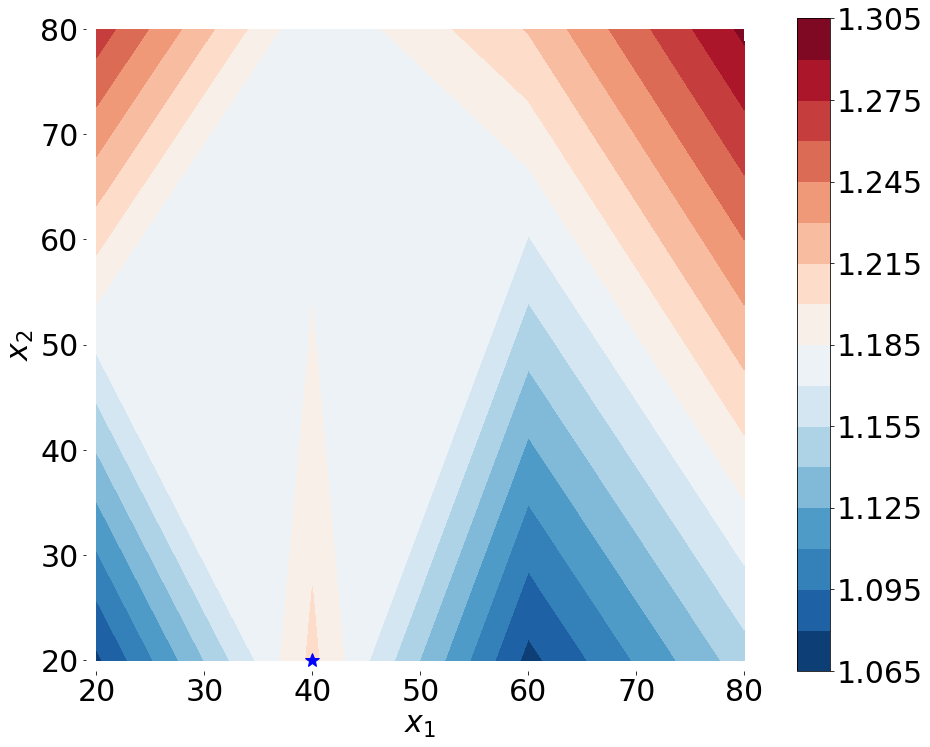

In [149]:
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import numpy as np
xi = np.array(two_res_list1)[:,1]
yi = np.array(two_res_list1)[:,2]
z = np.array(two_res_list1)[:,0]
triang = tri.Triangulation(xi, yi)
interpolator = tri.LinearTriInterpolator(triang, z)
Xi, Yi = np.meshgrid(xi, yi)
zi = interpolator(Xi, Yi)
plt.figure(figsize = (15,12))
plt.rcParams['font.size'] = 30
plt.contour(xi, yi, zi, levels=0, linewidths=0, colors='k')
cntr = plt.contourf(xi, yi, zi, levels=15, cmap="RdBu_r")
plt.colorbar(cntr)
plt.xlim(19, 81)
plt.ylim(19, 81)
plt.xlabel("${x_1}$")
plt.ylabel("${x_2}$")
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.plot([40], [20], 'b*', ms=15)
plt.show()

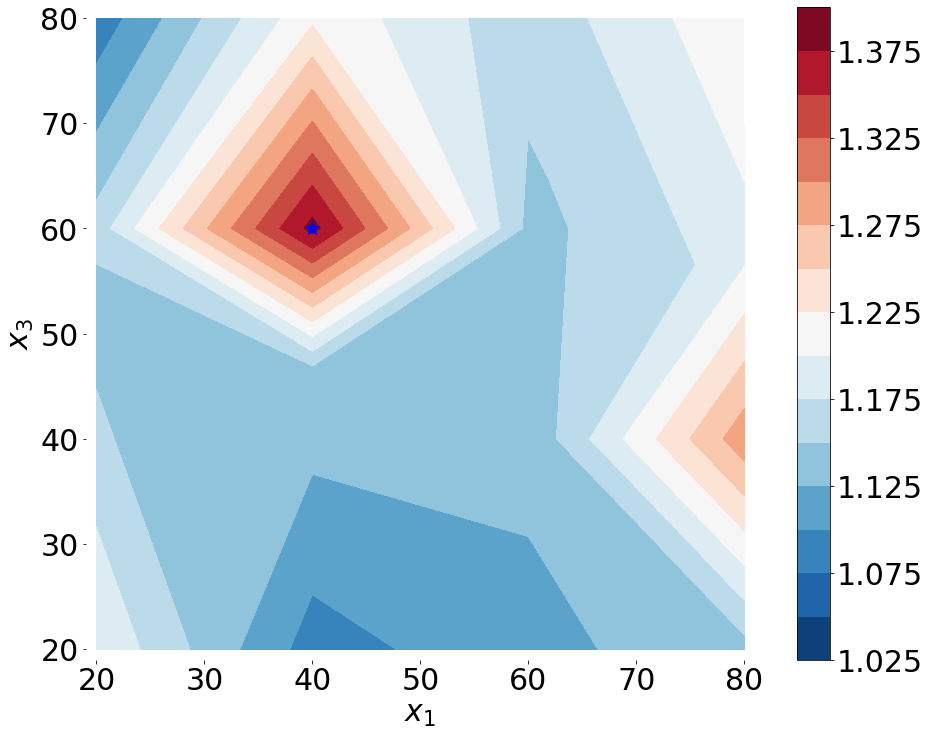

In [150]:
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import numpy as np
xi = np.array(two_res_list2)[:,1]
yi = np.array(two_res_list2)[:,2]
z = np.array(two_res_list2)[:,0]
triang = tri.Triangulation(xi, yi)
interpolator = tri.LinearTriInterpolator(triang, z)
Xi, Yi = np.meshgrid(xi, yi)
zi = interpolator(Xi, Yi)
plt.figure(figsize = (15,12))
plt.rcParams['font.size'] = 30
plt.contour(xi, yi, zi, levels=0, linewidths=0, colors='k')
cntr = plt.contourf(xi, yi, zi, levels=15, cmap="RdBu_r")
plt.colorbar(cntr)
plt.xlim(19, 81)
plt.ylim(19, 81)
plt.xlabel("${x_1}$")
plt.ylabel("${x_3}$")
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.plot([40], [60], 'b*', ms=15)
plt.show()

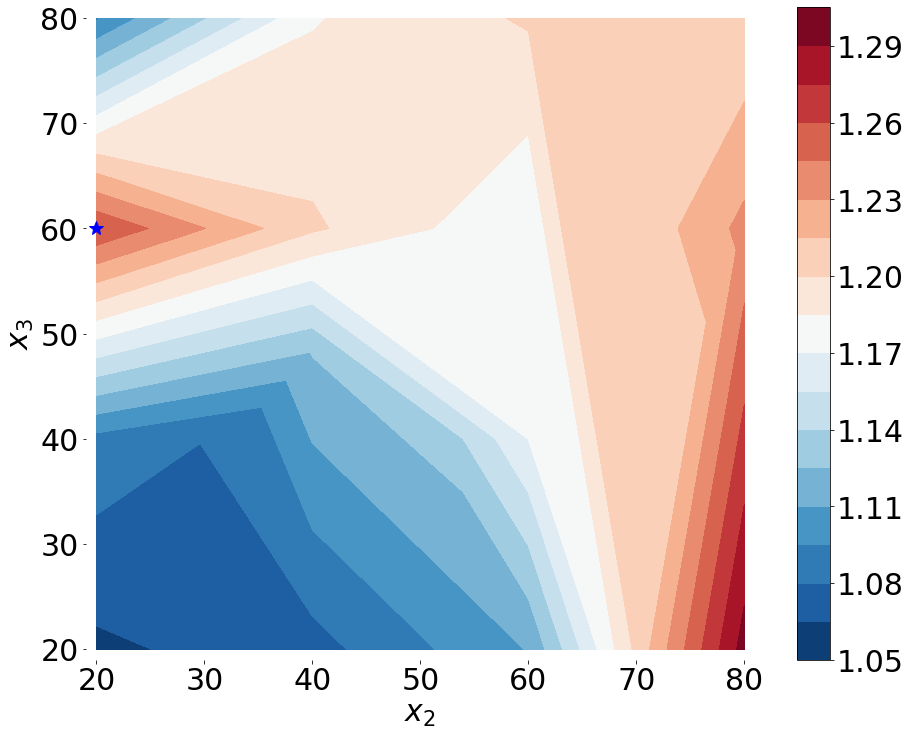

In [151]:
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import numpy as np
xi = np.array(two_res_list3)[:,1]
yi = np.array(two_res_list3)[:,2]
z = np.array(two_res_list3)[:,0]
triang = tri.Triangulation(xi, yi)
interpolator = tri.LinearTriInterpolator(triang, z)
Xi, Yi = np.meshgrid(xi, yi)
zi = interpolator(Xi, Yi)
plt.figure(figsize = (15,12))
plt.rcParams['font.size'] = 30
plt.contour(xi, yi, zi, levels=0, linewidths=0, colors='k')
cntr = plt.contourf(xi, yi, zi, levels=15, cmap="RdBu_r")
plt.colorbar(cntr)
plt.xlim(19, 81)
plt.ylim(19, 81)
plt.xlabel("${x_2}$")
plt.ylabel("${x_3}$")
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.plot([20], [60], 'b*', ms=15)
plt.show()